# Simulation Framework - When Do Pivotal Nodes Emerge? Tail Behavior and Bipartite Imbalance in Quota-Constrained Flow Networks

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations
from scipy.stats import truncnorm, t, pareto

import os
import imageio

# ============================================================
# 1) Sampling
# ============================================================

def sample_weights(dist_name: str, size: int, rng: np.random.Generator) -> np.ndarray:
    """Return strictly positive weights drawn from a specified distribution."""
    if size == 0:
        return np.array([])

    if dist_name == "gaussian":
        mu, sig = 100, 20
        a = (0 - mu) / sig
        return truncnorm.rvs(a, np.inf, loc=mu, scale=sig, size=size, random_state=rng)

    elif dist_name == "student_t":
        df, loc, scale = 3, 100, 20
        out = np.empty(size)
        filled = 0
        while filled < size:
            batch = t.rvs(df=df, loc=loc, scale=scale, size=(size - filled) * 3, random_state=rng)
            batch = batch[batch > 0]
            take = min(batch.size, size - filled)
            out[filled:filled + take] = batch[:take]
            filled += take
        return out

    elif dist_name == "power_law":
        shape, scale = 2, 50
        return pareto.rvs(b=shape, loc=0, scale=scale, size=size, random_state=rng)

    else:
        raise ValueError("dist_name must be one of: gaussian, student_t, power_law")


# ============================================================
# 2) Core metrics (P1, P2)
# ============================================================

def compute_p1(df_edges: pd.DataFrame, theta: float, exporters: np.ndarray) -> pd.DataFrame:
    """
    Vectorized P1:
    pivotal if w_ij > (1 - theta) * T_j.
    Returns one row per exporter with columns: exp, P1, targets
    """
    if df_edges.empty:
        return pd.DataFrame({
            "exp": exporters,
            "P1": np.zeros(exporters.size, dtype=int),
            "targets": np.zeros(exporters.size, dtype=int),
        })

    # Total inflow per target
    Tj = df_edges.groupby("imp")["weight"].sum().rename("Tj")
    df = df_edges.merge(Tj, on="imp", how="left")

    # threshold = (1 - theta) Tj
    df["thresh"] = (1.0 - theta) * df["Tj"]

    # pivotal condition
    df["piv1"] = (df["weight"] > df["thresh"]).astype(int)

    out = df.groupby("exp").agg(
        P1=("piv1", "sum"),
        targets=("imp", "nunique"),
    ).reset_index()

    out = pd.DataFrame({"exp": exporters}).merge(out, on="exp", how="left")
    out["P1"] = out["P1"].fillna(0).astype(int)
    out["targets"] = out["targets"].fillna(0).astype(int)
    return out


def compute_p2_capped(
    df_edges: pd.DataFrame,
    theta: float,
    max_preds: int,
    rng: np.random.Generator,
) -> pd.Series:
    """
    Capped P2 (tractable + consistent with your original code):

    For each target j:
      - Tj = sum_i w_ij
      - threshold = (1 - theta) * Tj
      - consider only non-pivotal-alone edges: w_ij <= threshold
      - (i1,i2) jointly pivotal if w1 + w2 > threshold (equivalently Tj - (w1+w2) < theta Tj)
      - cap non-piv list to max_preds via random subsample if needed

    Returns Series indexed by exporter with P2 counts.
    """
    if df_edges.empty:
        return pd.Series(dtype=int)

    p2_counts: dict[str, int] = {}
    Tj_map = df_edges.groupby("imp")["weight"].sum().to_dict()

    for imp_id, df_j in df_edges.groupby("imp"):
        Tj = Tj_map[imp_id]
        threshold = (1.0 - theta) * Tj

        preds = list(zip(df_j["exp"].to_list(), df_j["weight"].to_list()))
        non_piv = [(e, w) for e, w in preds if w <= threshold]

        if len(non_piv) < 2:
            continue

        # cap for tractability
        if len(non_piv) > max_preds:
            idx = rng.choice(len(non_piv), size=max_preds, replace=False)
            non_piv = [non_piv[i] for i in idx]

        for (e1, w1), (e2, w2) in combinations(non_piv, 2):
            if (w1 + w2) > threshold:
                p2_counts[e1] = p2_counts.get(e1, 0) + 1
                p2_counts[e2] = p2_counts.get(e2, 0) + 1

    return pd.Series(p2_counts, dtype=int)


# ============================================================
# 3) Summary stats
# ============================================================

def gini(x: np.ndarray) -> float:
    """Gini coefficient for nonnegative values."""
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if x.size == 0:
        return np.nan
    if np.all(x == 0):
        return 0.0
    x = np.sort(x)
    n = x.size
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n


def top_share(x: np.ndarray, frac: float) -> float:
    """Share of total mass contributed by top frac (e.g., 0.05)."""
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if x.size == 0:
        return np.nan
    tot = np.sum(x)
    if tot == 0:
        return 0.0
    k = max(1, int(np.ceil(frac * x.size)))
    xs = np.sort(x)[::-1]
    return float(np.sum(xs[:k]) / tot)


def conditional_stats(x: np.ndarray, frac: float = 0.05) -> dict:
    """Concentration stats conditional on x>0 (useful for zero-inflated P2)."""
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    pos = x[x > 0]
    if pos.size == 0:
        return {"gini_pos": np.nan, "top5_share_pos": np.nan, "n_pos": 0}
    return {
        "gini_pos": float(gini(pos)),
        "top5_share_pos": float(top_share(pos, frac)),
        "n_pos": int(pos.size),
    }


# ============================================================
# 4) Main simulation (supports scenario-specific p)
# ============================================================

def run_simulation(
    n_exporters: int,
    n_importers: int,
    p_edge: float,
    theta: float = 0.70,
    R: int = 100,
    max_preds: int = 12,
    seed: int = 42,
    dist_names: list[str] | None = None,
):
    """
    Returns:
      nodes_df: exporter-level rows for each replication + dist
      graphs_df: graph-level summary rows (one per dist x rep)
    """
    if dist_names is None:
        dist_names = ["gaussian", "student_t", "power_law"]

    rng = np.random.default_rng(seed)

    exporters = np.array([f"Exp_{i}" for i in range(n_exporters)])
    importers = np.array([f"Imp_{j}" for j in range(n_importers)])

    def generate_bipartite_edges(dist_name: str) -> pd.DataFrame:
        rows = []
        for e in exporters:
            mask = rng.random(n_importers) < p_edge
            chosen = importers[mask]
            w = sample_weights(dist_name, chosen.size, rng)
            rows.extend([(e, imp, float(wi)) for imp, wi in zip(chosen, w)])
        return pd.DataFrame(rows, columns=["exp", "imp", "weight"])

    all_nodes, all_graphs = [], []

    for dist in dist_names:
        for r in range(1, R + 1):
            df_edges = generate_bipartite_edges(dist)

            # P1 (and targets count)
            df_node = compute_p1(df_edges, theta, exporters=exporters)

            # capped P2
            p2 = compute_p2_capped(df_edges, theta, max_preds=max_preds, rng=rng)
            df_node["P2"] = df_node["exp"].map(p2).fillna(0).astype(int)

            df_node["dist"] = dist
            df_node["rep"] = r
            all_nodes.append(df_node)

            P1_vals = df_node["P1"].to_numpy()
            P2_vals = df_node["P2"].to_numpy()

            p2_cond = conditional_stats(P2_vals, frac=0.05)

            all_graphs.append({
                "dist": dist,
                "rep": r,
                "edges": int(len(df_edges)),
                "mean_targets": float(df_node["targets"].mean()),

                # P1 summaries
                "frac_P1_zero": float(np.mean(P1_vals == 0)),
                "max_P1": int(np.max(P1_vals)),              # integer per graph
                "gini_P1": float(gini(P1_vals)),
                "top5_share_P1": float(top_share(P1_vals, 0.05)),

                # P2 summaries (unconditional)
                "frac_P2_zero": float(np.mean(P2_vals == 0)),
                "max_P2": int(np.max(P2_vals)),              # integer per graph
                "gini_P2": float(gini(P2_vals)),
                "top5_share_P2": float(top_share(P2_vals, 0.05)),

                # P2 summaries (conditional on P2>0)
                "gini_P2_pos": p2_cond["gini_pos"],
                "top5_share_P2_pos": p2_cond["top5_share_pos"],
                "n_P2_pos": p2_cond["n_pos"],
            })

    nodes_df = pd.concat(all_nodes, ignore_index=True)
    graphs_df = pd.DataFrame(all_graphs)
    return nodes_df, graphs_df


# ============================================================
# 5) Visuals
# ============================================================

def make_plots(
    nodes_df: pd.DataFrame,
    graphs_df: pd.DataFrame,
    R: int,
    theta: float,
    output_dir: str,
    scenario_name: str,
    dist_names: list[str] | None = None,
) -> dict[str, str]:
    if dist_names is None:
        dist_names = ["gaussian", "student_t", "power_law"]

    saved_plot_paths = {}

    scenario_plot_dir = os.path.join(output_dir, scenario_name)
    os.makedirs(scenario_plot_dir, exist_ok=True)

    # (A) CCDF pooled - P1
    plt.figure(figsize=(8, 6))
    rng_jitter = np.random.default_rng(seed=42) # Use a consistent RNG for jitter

    for dist in dist_names:
        x = nodes_df.loc[nodes_df["dist"] == dist, "P1"].to_numpy()
        x = x[x > 0] # Filter out non-positive values for log scale

        if x.size == 0:
            continue

        xs = np.sort(x)
        ccdf = 1.0 - np.arange(1, xs.size + 1) / xs.size
        plt.step(xs, ccdf, where="post", label=dist)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("P1") # Revert label
    plt.ylabel("CCDF(P1)")
    plt.title(f"Tail behavior of P1 (pooled over R={R}, θ={theta:.2f}) - {scenario_name}")
    plt.legend()
    plt.tight_layout()
    plot_path = os.path.join(scenario_plot_dir, "P1_ccdf.png")
    plt.savefig(plot_path)
    plt.close()
    saved_plot_paths["P1_ccdf"] = plot_path

    # (B) Max P1 per graph boxplot
    plt.figure(figsize=(8, 5))
    data = [graphs_df.loc[graphs_df["dist"] == dist, "max_P1"].to_numpy() for dist in dist_names]
    plt.boxplot(data, tick_labels=dist_names)
    plt.ylabel("max P1 (per graph)")
    plt.title(f"Distribution of max P1 across R={R} replications - {scenario_name}")
    plt.tight_layout()
    plot_path = os.path.join(scenario_plot_dir, "max_P1.png")
    plt.savefig(plot_path)
    plt.close()
    saved_plot_paths["max_P1"] = plot_path

    # (C) frac P1=0
    plt.figure(figsize=(8, 5))
    data = [graphs_df.loc[graphs_df["dist"] == dist, "frac_P1_zero"].to_numpy() for dist in dist_names]
    plt.boxplot(data, tick_labels=dist_names)
    plt.ylabel("Fraction of exporters with P1 = 0")
    plt.title(f"How often pivotality is absent (by regime) - {scenario_name}")
    plt.tight_layout()
    plot_path = os.path.join(scenario_plot_dir, "frac_P1_zero.png")
    plt.savefig(plot_path)
    plt.close()
    saved_plot_paths["frac_P1_zero"] = plot_path

    # (D) CCDF pooled - P2
    plt.figure(figsize=(8, 6))
    for dist in dist_names:
        x = nodes_df.loc[nodes_df["dist"] == dist, "P2"].to_numpy()
        x = x[x > 0]
        if x.size == 0:
            continue
        xs = np.sort(x)
        ccdf = 1.0 - np.arange(1, xs.size + 1) / xs.size
        plt.step(xs, ccdf, where="post", label=dist)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("P2")
    plt.ylabel("CCDF(P2)")
    plt.title(f"Tail behavior of P2 (pooled over R={R}, θ={theta:.2f}) - {scenario_name}")
    plt.legend()
    plt.tight_layout()
    plot_path = os.path.join(scenario_plot_dir, "P2_ccdf.png")
    plt.savefig(plot_path)
    plt.close()
    saved_plot_paths["P2_ccdf"] = plot_path

    # (E) P1 vs P2 Scatter Plot
    plt.figure(figsize=(8, 6))
    for dist in dist_names:
        df_dist = nodes_df.loc[nodes_df["dist"] == dist]
        p1_scatter = df_dist["P1"].copy().to_numpy().astype(float)
        p2_scatter = df_dist["P2"].copy().to_numpy().astype(float)

        # Jitter for P1 = 0, 1, 2 similar to CCDF
        mask_zero_p1 = (p1_scatter == 0)
        if np.any(mask_zero_p1):
            p1_scatter[mask_zero_p1] = rng_jitter.uniform(1e-5, 1e-4, size=np.sum(mask_zero_p1))
        mask_one_p1 = (p1_scatter == 1)
        if np.any(mask_one_p1):
            p1_scatter[mask_one_p1] += rng_jitter.uniform(-0.4, 0.4, size=np.sum(mask_one_p1))
            p1_scatter[mask_one_p1] = np.maximum(p1_scatter[mask_one_p1], 0.05)
        mask_two_p1 = (p1_scatter == 2)
        if np.any(mask_two_p1):
            p1_scatter[mask_two_p1] += rng_jitter.uniform(-0.4, 0.4, size=np.sum(mask_two_p1))
            p1_scatter[mask_two_p1] = np.maximum(p1_scatter[mask_two_p1], 0.05)

        # Jitter for P2 = 0, 1, 2 for consistency and visibility
        mask_zero_p2 = (p2_scatter == 0)
        if np.any(mask_zero_p2):
            p2_scatter[mask_zero_p2] = rng_jitter.uniform(1e-5, 1e-4, size=np.sum(mask_zero_p2))
        mask_one_p2 = (p2_scatter == 1)
        if np.any(mask_one_p2):
            p2_scatter[mask_one_p2] += rng_jitter.uniform(-0.4, 0.4, size=np.sum(mask_one_p2))
            p2_scatter[mask_one_p2] = np.maximum(p2_scatter[mask_one_p2], 0.05)
        mask_two_p2 = (p2_scatter == 2)
        if np.any(mask_two_p2):
            p2_scatter[mask_two_p2] += rng_jitter.uniform(-0.4, 0.4, size=np.sum(mask_two_p2))
            p2_scatter[mask_two_p2] = np.maximum(p2_scatter[mask_two_p2], 0.05)

        plt.scatter(p1_scatter, p2_scatter, alpha=0.5, label=dist, s=5) # s=5 for smaller points

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("P1 (with jitter for 0, 1, 2)")
    plt.ylabel("P2 (with jitter for 0, 1, 2)")
    plt.title(f"P1 vs P2 for all exporters (pooled over R={R}, θ={theta:.2f}) - {scenario_name}")
    plt.legend()
    plt.tight_layout()
    plot_path_P1_P2_scatter = os.path.join(scenario_plot_dir, "P1_P2_scatter.png")
    plt.savefig(plot_path_P1_P2_scatter)
    plt.close()
    saved_plot_paths["P1_P2_scatter"] = plot_path_P1_P2_scatter

    return saved_plot_paths


# ============================================================
# 6) Scenarios + GIFs
#    Changing p:
#        (A) fixed p across scenarios, or
#        (B) adjust p to keep expected target in-degree Mp constant.
# ============================================================

if __name__ == "__main__":
    theta_param = 0.70
    R_param = 100
    max_preds_param = 12
    seed_param = 42

    # scenarios for (M,N)
    scenarios = [
        (140, 60),
        (130, 70),
        (120, 80),
        (110, 90),
        (100, 100),
        (90, 110),
        (80, 120),
        (70, 130),
        (60, 140),
    ]

    # === Choose p rule ===
    # Option A: fixed p across all scenarios (old behavior)
    # p_edge_base = 0.10
    # def p_rule(M, N): return p_edge_base

    # Option B: adjust p to keep expected target in-degree E[d_j]=Mp constant (recommended for your imbalance story)
    target_degree = 20
    def p_rule(M, N):
        p = target_degree / M
        return float(min(max(p, 0.0), 1.0))

    base_output_dir = "simulation_outputs"
    os.makedirs(base_output_dir, exist_ok=True)

    all_scenario_plot_paths = {
        "P1_ccdf": [],
        "max_P1": [],
        "frac_P1_zero": [],
        "P2_ccdf": [],
        "P1_P2_scatter": []
    }

    print("Running simulations for multiple scenarios...")
    for M, N in scenarios:
        p_edge_param = p_rule(M, N)
        scenario_name = f"exp{M}_imp{N}_p{p_edge_param:.3f}"
        print(f"\n--- Running scenario: {scenario_name} ---")

        nodes_df, graphs_df = run_simulation(
            n_exporters=M,
            n_importers=N,
            p_edge=p_edge_param,
            theta=theta_param,
            R=R_param,
            max_preds=max_preds_param,
            seed=seed_param
        )

        current_scenario_plot_paths = make_plots(
            nodes_df,
            graphs_df,
            R=R_param,
            theta=theta_param,
            output_dir=base_output_dir,
            scenario_name=scenario_name
        )

        for plot_type, path in current_scenario_plot_paths.items():
            all_scenario_plot_paths[plot_type].append(path)

        # Summary tables (means across replications)
        graphs_means = graphs_df.groupby("dist")[[
            "max_P1", "frac_P1_zero", "gini_P1", "top5_share_P1",
            "max_P2", "frac_P2_zero", "gini_P2", "top5_share_P2",
            "gini_P2_pos", "top5_share_P2_pos", "n_P2_pos",
            "mean_targets", "edges"
        ]].mean()


        graphs_means = graphs_means.rename(columns={
            "max_P1": "averageP1max",
            "max_P2": "averageP2max"
        })

        print("\nGraph-level summary means (across replications):")
        print(graphs_means[[
            "averageP1max","frac_P1_zero","gini_P1","top5_share_P1",
            "averageP2max","frac_P2_zero","gini_P2","top5_share_P2",
            "gini_P2_pos","top5_share_P2_pos","n_P2_pos",
            "mean_targets","edges"
        ]])

    print("\n--- Creating GIFs ---")
    for plot_type, paths in all_scenario_plot_paths.items():
        if paths:
            gif_path = os.path.join(base_output_dir, f"{plot_type}_evolution.gif")
            images = [imageio.v2.imread(p) for p in paths]
            imageio.mimsave(gif_path, images, fps=1)
            print(f"Created GIF: {gif_path}")
        else:
            print(f"No images found for plot type: {plot_type}, skipping.")

    print("\nSimulation and GIF creation complete. Check the 'simulation_outputs' directory.")

Running simulations for multiple scenarios...

--- Running scenario: exp140_imp60_p0.143 ---

Graph-level summary means (across replications):
           averageP1max  frac_P1_zero   gini_P1  top5_share_P1  averageP2max  \
dist                                                                           
gaussian           0.00      1.000000  0.000000        0.00000          0.14   
power_law          1.11      0.959357  0.959908        0.96153         10.06   
student_t          0.07      0.999500  0.069500        0.07000          0.93   

           frac_P2_zero   gini_P2  top5_share_P2  gini_P2_pos  \
dist                                                            
gaussian       0.998571  0.058833       0.060000     0.150000   
power_law      0.762714  0.853853       0.546757     0.365567   
student_t      0.990714  0.193600       0.187889     0.212169   

           top5_share_P2_pos  n_P2_pos  mean_targets    edges  
dist                                                           
ga

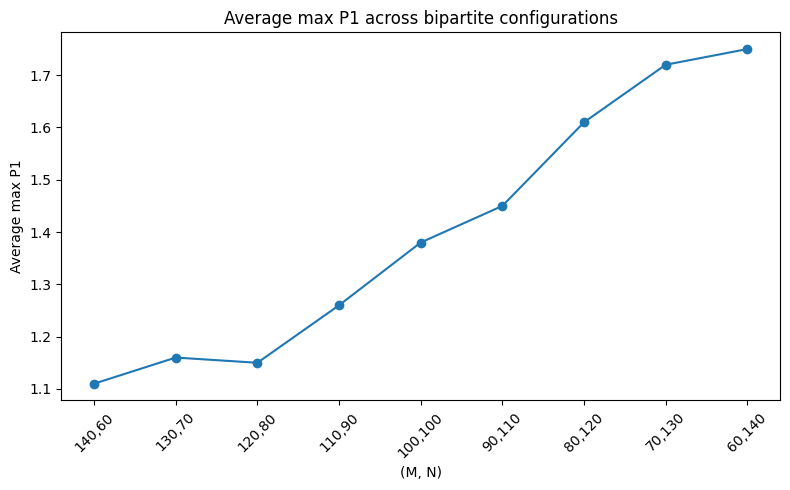

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
M = np.array([140,130,120,110,100,90,80,70,60])
N = np.array([60,70,80,90,100,110,120,130,140])
avg_P1_max = np.array([1.11,1.16,1.15,1.26,1.38,1.45,1.61,1.72,1.75])

# Imbalance ratio (recommended)
ratio = N / M   # exposure ratio

# Plot
labels = [f"{m},{n}" for m,n in zip(M,N)]

plt.figure(figsize=(8,5))
plt.plot(labels, avg_P1_max, marker='o')
plt.xlabel("(M, N)")
plt.ylabel("Average max P1")
plt.title("Average max P1 across bipartite configurations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

